In [1]:
import swe.shallowwater as sw
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
D = [0, 50]
T = 10
dt = 0.05
N = 50
bathy = None

h0 = lambda x: 20 * np.ones_like(x)
u0 = lambda x: np.zeros_like(x)
K = [0.5]

bcL = lambda h, hu, t: sw.BCsin(h, hu, t, 20, [5], 8, 0)

test_conf = sw.ShallowWaterSimulation(D=D, T=T, dt=dt, h0=h0, u0=u0, K=K, bcL=bcL, N=N)
test_conf.numflux.func_name = "LF_flux"


In [3]:
test_conf.summary()


1DSW Simulation:
D=[0, 50], dx=1.0, Nvol=50
T=10, dt=0.05, Ntimesteps=201

Numerical Flux: LF_flux


In [4]:
print(test_conf)


1DSW Simulation:
D=[0, 50], dx=1.0, Nvol=50
T=10, dt=0.05, Ntimesteps=201


In [5]:
## Wrappers to call the solver, and tangent linear


def forward_model(K):
    simu = sw.ShallowWaterSimulation(D=D, T=T, dt=dt, h0=h0, u0=u0, K=K, bcL=bcL, N=N)
    xr, h, u, t = simu.direct_simulation()
    return h


def tangent_linear(K, dK):
    simu = sw.ShallowWaterSimulation(D=D, T=T, dt=dt, h0=h0, u0=u0, K=K, bcL=bcL, N=N)
    return simu.tangent_linear(dK)


def jacobian_matrix(K):
    sim = sw.ShallowWaterSimulation(D=D, T=T, dt=dt, h0=h0, u0=u0, K=K, bcL=bcL, N=N)
    return sim.jacobian_matrix(dim=len(K))


In [6]:
# Test of the consistency of the TLM

dim_K = 5
alpha_list = [10.0 ** (-i) for i in np.arange(2, 9)]


K0 = np.random.uniform(size=dim_K)
dK0 = np.random.uniform(size=dim_K)
h_t_flat = forward_model(K0).flatten()
fd = []
diff = []
for alp in alpha_list:
    h_t_alp = forward_model(K0 + alp * dK0).flatten()
    diff.append((h_t_alp - h_t_flat) / alp)
    fd.append(np.sum((h_t_alp - h_t_flat) ** 2))


Text(0.5, 1.0, 'Consistency TLM and finite difference\nV shape expected')

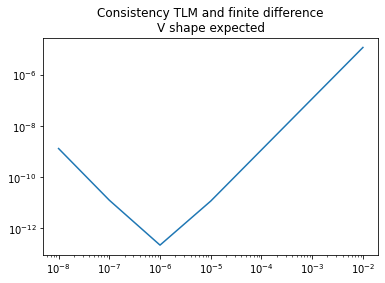

In [7]:
diff = np.array(diff).reshape(len(alpha_list), N, int(T / dt) + 1)
h_d, q_d, dj = tangent_linear(K0, dK0)
plt.plot(alpha_list, ((diff - h_d) ** 2).sum(1).sum(1))
plt.yscale("log")
plt.xscale("log")
plt.title(f"Consistency TLM and finite difference\nV shape expected")


In [8]:
# Check consistency between jacobian matrix and finite differences

jac = jacobian_matrix(K0)


h_t_flat = forward_model(K0).flatten()
fd_jac = np.empty((len(h_t_flat), len(K0)))
print("||jacobian - finite_difference jacobian||")
for alpha in alpha_list:
    for i in range(len(K0)):
        dK0 = np.zeros_like(K0)
        dK0[i] = 1
        fd_jac[:, i] = (forward_model(K0 + alpha * dK0).flatten() - h_t_flat) / alpha
    print(f"{alpha}, {((jac - fd_jac)**2).mean()}")


||jacobian - finite_difference jacobian||
0.01, 9.491299937969669e-11
0.001, 9.499831670255681e-13
0.0001, 9.500684665301154e-15
1e-05, 9.49176091088001e-17
1e-06, 1.3480791628496713e-17
1e-07, 1.3057979180281668e-15
1e-08, 1.2067402641470135e-13


In [9]:
# Create a reference trajectory for the SSH
K_truth = np.array([0.2])
h_t = forward_model(K_truth)

yobs = h_t + 0.5 * np.random.normal(size=h_t.shape)


In [10]:
# Create observation matrix
def observation_matrix_init(h_test, ind_to_observe=None):
    if ind_to_observe is None:
        ind_to_observe = range(int(h_test.shape[0]))
    obs_mat = np.zeros((h_test.shape[0], h_test.shape[0]))
    obs_mat[ind_to_observe, ind_to_observe] = 1
    return obs_mat


obs_mat = observation_matrix_init(yobs)


In [11]:
## Wrapper to compute the cost and the gradient wrt to a reference
def cost_gradient(K, reference):
    simu = sw.ShallowWaterSimulation(D=D, T=T, dt=dt, h0=h0, u0=u0, K=K, bcL=bcL, N=N)
    simu.set_reference(reference)
    simu.cost_fun = lambda x, y: 0.5 * np.mean((x - y) ** 2)

    simu.obs_mat = obs_mat
    cost, grad = simu.compute_cost_and_gradient()

    grad_sum_length = int(simu.xr.shape[0] / len(K))
    grad_coeff = np.zeros(len(K))
    for i in range(len(K)):
        grad_coeff[i] = sum(
            grad[i * grad_sum_length : (i * grad_sum_length + grad_sum_length)]
        )
    return cost, grad_coeff / np.prod(h_t.shape)


100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


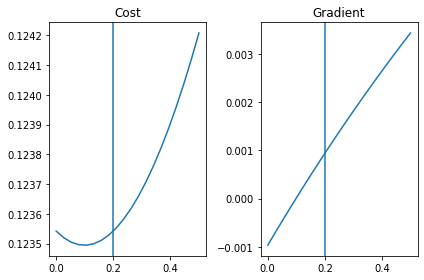

In [12]:
c_li, g_li = [], []
k_evals = np.linspace(0, 0.5, 20)
for k in tqdm(k_evals):
    c, g = cost_gradient([k], yobs)
    c_li.append(c)
    g_li.append(g)
plt.subplot(1, 2, 1)
plt.plot(k_evals, c_li)
plt.axvline(K_truth)
plt.title("Cost")
plt.subplot(1, 2, 2)
plt.plot(k_evals, g_li)
plt.axvline(K_truth)
plt.title("Gradient")
plt.tight_layout()


In [13]:
n_grid = 10
k_ = np.linspace(0, 0.5, n_grid)
K_1, K_2 = np.meshgrid(k_, k_)
K_grid = np.array((K_1, K_2)).T.reshape(-1, 2)
cost_grid = np.empty(len(K_grid))
grad_grid = np.empty((len(K_grid), 2))

for i, k in enumerate(tqdm(K_grid)):
    # print(i, k)
    cost_grid[i], grad_grid[i, :] = cost_gradient(k, yobs)


100%|██████████| 100/100 [04:07<00:00,  2.47s/it]


Text(0.5, 1.0, 'Cost function')

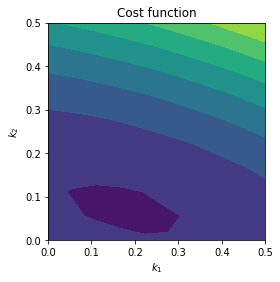

In [14]:
plt.contourf(K_1, K_2, cost_grid.reshape(n_grid, n_grid))
plt.gca().set_aspect('equal')
plt.xlabel(r"$k_1$")
plt.ylabel(r"$k_2$")
plt.title(f"Cost function")

In [15]:
# Consistency check for the gradient and finite differences

k_test_grad = np.random.uniform()
c_test, g_test = cost_gradient([k_test_grad], yobs)
c_eps = []
print(c_test, g_test)
for eps in [1e-3, 1e-5, 1e-7, 1e-9]:
    simu = sw.ShallowWaterSimulation(
        D=D, T=T, dt=dt, h0=h0, u0=u0, K=[k_test_grad + eps], bcL=bcL, N=N
    )
    simu.idx_observation = np.arange(len(simu.xr), dtype="int")
    simu.set_reference(yobs)
    cost = simu.compute_cost()
    print(eps, cost, g_test - (cost - c_test) / eps)
    c_eps.append(cost)


0.12391009781132953 [0.0026632]
0.001 0.1239127650483097 [-4.03472847e-06]
1e-05 0.12391012444375563 [-4.03580804e-08]
1e-07 0.12391009807764981 [-6.00993897e-10]
1e-09 0.1239100978139927 [2.70158038e-08]
